
# Non personalized recommenders

### Load data

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
recsys_path = "/content/gdrive/MyDrive/recsys/"
data_path = recsys_path + 'data/'
data_train_path = data_path + "data_train.csv"

In [3]:
import os

# create folders and load data from github
if not os.path.exists(data_path):
    os.makedirs(data_path)
    os.chdir(recsys_path)
    !git clone https://github.com/fulcus/recommender-systems-challenge.git
    !mv recommender-systems-challenge/data data
    !rm -rf recommender-systems-challenge
  
os.chdir(recsys_path)

#### Let's take a look at the data

In [4]:
import pandas as pd

In [5]:
URM_all_dataframe = pd.read_csv(data_train_path, dtype={0:int, 1:int, 2:int})
URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [6]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction
0,0,53,1
1,0,209,1
2,0,223,1
3,0,249,1
4,0,435,1
5,0,460,1
6,0,652,1
7,0,960,1
8,0,973,1
9,0,1103,1


In [7]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 5285664


### We can use this data to create a sparse matrix, since we have red UserID and ItemID as int

### Now we can extract the list of unique user id and item id and display some statistics

### There are no empty profiles or items, and indexes already start from *0*


In [8]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 18059, Number of users	 13650
Max ID items	 18058, Max Id users	 13649

Average interactions per user 387.23
Average interactions per item 292.69

Sparsity 97.86 %


#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [9]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<13650x18059 sparse matrix of type '<class 'numpy.int64'>'
	with 5285664 stored elements in COOrdinate format>

In [10]:
#URM_all.tocsr()

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [11]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([ 14, 156,  49, ..., 458,  48,  98], dtype=int32)

In [12]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    3,     3,     3, ..., 10109, 10118, 11199], dtype=int32)

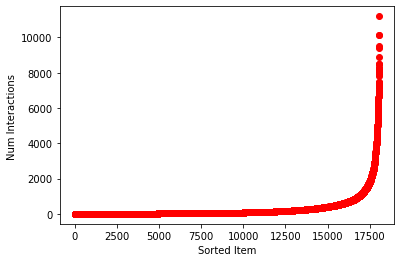

In [13]:
import matplotlib.pyplot as pyplot

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

x axis is index of array (monotonic because it is sorted), y axis value of element with corresponding x

In [14]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 292.69
Average per-item interactions for the top 10% popular items 1847.99
Average per-item interactions for the least 10% popular items 9.60
Average per-item interactions for the median 10% popular items 65.58


In [15]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

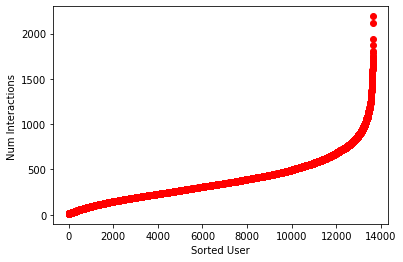

In [16]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A functon computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [17]:
train_test_split = 0.80

n_interactions = URM_all.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ...,  True,  True, False])

In [18]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<13650x18059 sparse matrix of type '<class 'numpy.longlong'>'
	with 4228308 stored elements in Compressed Sparse Row format>

In [19]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<13650x18059 sparse matrix of type '<class 'numpy.longlong'>'
	with 1057356 stored elements in Compressed Sparse Row format>

### Evaluation metric

#### We call items in the test set 'relevant'

In [20]:
user_id = 124
relevant_items = URM_test[user_id].indices
relevant_items

array([  460,  1005,  1533,  1614,  2248,  3473,  4602,  4742,  4853,
        6175,  6903,  7430,  7870,  8207,  8598,  8635, 10778, 10843,
       10865, 11339, 11491, 11796, 12015, 12272, 12707, 13092, 13237,
       13291, 13410, 14010, 14400, 15117, 15277, 16365, 16580, 17291,
       17463, 17584], dtype=int32)

#### Say that we have a recommendation list such as this

In [21]:
recommended_items = np.array([460, 11662, 15, 857, 5823])
recommended_items

array([  460, 11662,    15,   857,  5823])

In [22]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([ True, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [23]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

### Recall: how many of the relevant items I was able to recommend

In [24]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Mean Average Precision

In [25]:
def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Let's start with a random recommender

#### In a random recommend we don't have anything to learn from the data

In [26]:
# ndarray to space separed string
def array_to_string(array):
    return [' '.join(str(y) for y in x) for x in array]

In [27]:
class RandomRecommender(object):

    def fit(self, URM_train):
           
        self.n_items = URM_train.shape[1]
    
    
    def recommend(self, user_id, at=10):
    
        recommended_items = np.random.choice(self.n_items, at)

        return recommended_items
    

    def recommend_to_dataframe(self, df_users, at=10):

        #for each row of df_users, return list of items, and add to column "item_list"
        df_users['item_list'] = array_to_string([np.random.choice(self.n_items, at) for u in df_users['user_id']])

        return df_users

In [28]:
randomRecommender = RandomRecommender()
randomRecommender.fit(URM_train)

In [29]:
for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=10))

[15465  5228  8766  4861 17397  8988 10288  9680  8339 15424]
[ 3677 12127 15100  5356 10259 11181   634 17008 13240  9144]
[15820 16192  7591  1822  1105 13725  1239 10472 16062  8252]
[11188 12240  5373 14604 12879 14541 10937 13245  2060 14188]
[ 8985  5049 10399 15262 14537  2055  3695 12884 16869 14100]
[13927 14642 14651  8679 12210  4870 11264  5928 15419  2357]
[ 4253  4949  5944  1089 18034  4040 15438  4912  6877  3044]
[ 7170 12802 14819 17731 15157 10098 14502  2568 12349  8353]
[ 3282  5992  4747  9951  8486  5768  1346  3755 14395  2210]
[ 7806  2050 13596 16794 13080  8217 15882 17369  5326  5644]


### Put all together in an evaluation function and let's test it!

In [30]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=10):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 


In [31]:
evaluate_algorithm(URM_test, randomRecommender)

Recommender results are: Precision = 0.0048, Recall = 0.0006, MAP = 0.0015


### So the code works. The performance however...

# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity

In [32]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=10):
    
        recommended_items = self.popular_items[0:at]

        return recommended_items

    def recommend_to_dataframe(self, df_users, at=10):
        recommended_items = self.popular_items[0:at]

        #for each row of df_users, return list of items, and add to column "item_list"
        df_users['item_list'] = array_to_string([recommended_items for u in df_users['user_id']])

        return df_users

### Now train and test our model

In [33]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

In [34]:
for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=10))

[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]
[ 6177  3899  3473  6214  8635 17330 16365 15119  5273 14181]


In [35]:
evaluate_algorithm(URM_test, topPopRecommender, at=10)

Recommender results are: Precision = 0.1366, Recall = 0.0254, MAP = 0.0588


### That's better, but we can improve

### Remove items already seen by the user. We can either remove them from the recommended item list or we can set them to a score so low that it will cause them to end at the very bottom of all the available items

In [36]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=10, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.popular_items, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            
        return recommended_items

    def recommend_to_dataframe(self, df_users, at=10):

        #for each row of df_users, return list of items, and add to column "item_list"
        df_users['item_list'] = array_to_string([self.recommend(id) for id in df_users['user_id']])

        return df_users

In [37]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(URM_train)

for user_id in range(10):
    print(topPopRecommender_removeSeen.recommend(user_id, at=10))

[ 3899  8635 16365 10865  2665 13134 15778 13914 13229  3768]
[ 3473 16365 15119 14181 14358  2665  5925  1259 14868   640]
[ 6177  3899  6214 17330 16365 15119  5273 14181 16846 10865]
[ 3899  3473  6214  8635 17330 16365 15119  5273 14181 14358]
[ 6177  3473 16365  2665 15778 13229  3768  1259 14868  5403]
[ 3899  3473  6214  8635 17330 16365 15119  5273 14181 14358]
[ 3473  6214  8635 17330  5273 14181 14358 16846  2665 13134]
[ 3899  3473  8635 17330 15119  5273 14181 14358 16846 13134]
[ 8635 17330 10865  2665 15778  5925 13229  6975  3768  1551]
[ 6177  3473  6214  8635 17330 16365 15119 14181 16846 10865]


In [38]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen)

Recommender results are: Precision = 0.2835, Recall = 0.0458, MAP = 0.1700


#### Simple but effective. Always remove seen items if your purpose is to recommend "new" ones

# Predict

## Random test

In [39]:
data_pred = data_path + "data_target_users_test.csv"

In [40]:
URM_pred = pd.read_csv(data_pred,
                                dtype={0:int, 1:int, 2:int})

In [41]:
randomRecommender.fit(URM_all)

In [42]:
df_pred = randomRecommender.recommend_to_dataframe(URM_pred)

In [43]:
df_pred

,user_id,item_list
0,0,8513 1598 8288 13897 16770 15245 4721 9675 121...
1,1,1280 9721 14359 5925 7466 11409 6611 697 3478 ...
2,2,10368 8582 928 1713 10443 6287 16890 9723 7603...
3,3,12091 6859 5625 8834 7833 12417 17925 12717 90...
4,4,5275 2923 17620 5346 15931 4415 3413 15505 169...
...,...,...
13645,13645,15992 17295 10644 2172 13292 6285 10377 9737 4...
13646,13646,14712 14764 6759 17968 1054 8578 3447 5348 689...
13647,13647,11958 8509 13036 10269 10187 13361 5544 16339 ...
13648,13648,2855 17170 7320 6852 4608 15257 13396 4624 162...


In [44]:
path = data_path + 'random.csv'
#if not os.path.exists(path):
df_pred.to_csv(path, index=False)

## TopPop test

In [45]:
topPopRecommender.fit(URM_all)

In [46]:
df_pred_top = topPopRecommender.recommend_to_dataframe(URM_pred)

In [47]:
df_pred_top

,user_id,item_list
0,0,6177 3899 3473 6214 8635 17330 16365 15119 527...
1,1,6177 3899 3473 6214 8635 17330 16365 15119 527...
2,2,6177 3899 3473 6214 8635 17330 16365 15119 527...
3,3,6177 3899 3473 6214 8635 17330 16365 15119 527...
4,4,6177 3899 3473 6214 8635 17330 16365 15119 527...
...,...,...
13645,13645,6177 3899 3473 6214 8635 17330 16365 15119 527...
13646,13646,6177 3899 3473 6214 8635 17330 16365 15119 527...
13647,13647,6177 3899 3473 6214 8635 17330 16365 15119 527...
13648,13648,6177 3899 3473 6214 8635 17330 16365 15119 527...


In [48]:
path = data_path + 'top.csv'
#if not os.path.exists(path):
df_pred_top.to_csv(path, index=False)

## TopPopRemoveSeen test

In [49]:
URM_all_csr = URM_all.tocsr()

In [50]:
topPopRecommender_removeSeen.fit(URM_all_csr)

In [51]:
df_pred_top_removeseen = topPopRecommender_removeSeen.recommend_to_dataframe(URM_pred)

In [52]:
df_pred_top_removeseen

,user_id,item_list
0,0,3899 8635 16365 2665 13134 15778 13914 13229 3...
1,1,3473 16365 15119 14358 2665 14868 640 8207 134...
2,2,6177 17330 16365 15119 5273 14181 16846 10865 ...
3,3,3899 3473 6214 8635 17330 16365 15119 5273 141...
4,4,6177 3473 2665 15778 1259 14868 5403 6011 6652...
...,...,...
13645,13645,6177 14358 2665 15778 13914 6975 3768 1259 148...
13646,13646,3473 8635 5273 13134 13229 1551 1259 14868 113...
13647,13647,8635 17330 5273 14181 16846 2665 13134 5925 13...
13648,13648,6177 6214 8635 15119 5273 14181 14358 13134 59...


In [53]:
path = data_path + 'top-removeseen.csv'
#if not os.path.exists(path):
df_pred_top_removeseen.to_csv(path, index=False)